# SRGAN Model

In [1]:
!pip install torch-summary
!pip install grad-cam

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.autograd import Function
from torch.hub import load_state_dict_from_url

In [2]:
# Copyright 2020 Dakewe Biotech Corporation. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

model_urls = {
    "srgan": "https://github.com/Lornatang/SRGAN-PyTorch/releases/download/0.1.0/SRGAN_4x4_16_DIV2K-57e43f2f.pth"
}


class Generator(nn.Module):
    r"""The main architecture of the generator."""

    def __init__(self):
        r""" This is an esrgan model defined by the author himself.
        """
        super(Generator, self).__init__()
        # First layer.
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        # 16 Residual blocks.
        residual_blocks = []
        for _ in range(16):
            residual_blocks.append(ResidualBlock(64))
        self.Trunk = nn.Sequential(*residual_blocks)

        # Second conv layer post residual blocks.
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )

        # 2 Upsampling layers.
        upsampling = []
        for _ in range(2):
            upsampling.append(UpsampleBlock(256))
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer.
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out1 = self.conv1(input)
        out = self.Trunk(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)

        return out


class UpsampleBlock(nn.Module):
    r"""Main upsample block structure"""

    def __init__(self, channels):
        r"""Initializes internal Module state, shared by both nn.Module and ScriptModule.

        Args:
            channels (int): Number of channels in the input image.
        """
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels // 4, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)
        self.prelu = nn.PReLU()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.conv(input)
        out = self.pixel_shuffle(out)
        out = self.prelu(out)

        return out


class ResidualBlock(nn.Module):
    r"""Main residual block structure"""

    def __init__(self, channels):
        r"""Initializes internal Module state, shared by both nn.Module and ScriptModule.

        Args:
            channels (int): Number of channels in the input image.
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.conv1(input)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        return out + input

def _gan(arch, pretrained, progress):
    model = Generator()
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress,
                                              map_location=torch.device("cpu"))
        model.load_state_dict(state_dict)
    return model


def srgan(pretrained: bool = False, progress: bool = True) -> Generator:
    r"""GAN model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1609.04802>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _gan("srgan", pretrained, progress)

In [3]:
# load model
model = Generator()

# SRGAN with classifier

In [4]:
# dropout set to 0.5
class New_Classifier(nn.Module):
    def __init__(self):
        super(New_Classifier, self).__init__()

        self.fc1 = nn.Linear(3*176*176, 1024)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.dropout = nn.Dropout(p=0.5,inplace=False)
        self.fc2 = nn.Linear(1024, 5)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.fc1(input)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x

# add downstream task
model.conv3 =  nn.Sequential(nn.Conv2d(64, 3, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                             nn.LeakyReLU(negative_slope=0.2, inplace=True),
                             nn.Flatten(), 
                            New_Classifier()
                            )

In [5]:
# enter the number of residual blocks to remove
remove_blocks = 2

del model.Trunk[16-remove_blocks:16]

# SRGAN Class Prediction

In [6]:
# load pretrained weights
input_path = '../demo/cassava_downstream_generator_demo_Resize128_Centercrop88_Remove2ResBlocks_Dropout05.pth'

checkpoint = torch.load(input_path)
model.load_state_dict(checkpoint)

# freeze weights from pretrained network
for param in model.parameters():
    param.requires_grad = False
    
# retrain layers that follow
model.conv2.requires_grad = True
model.conv3.requires_grad = True
model.upsampling.requires_grad = True

In [7]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
model = model.to(device)

img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((88, 88)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='../demo', transform=img_transform)
test_loader = DataLoader(dataset, batch_size=1, drop_last=True, num_workers=8, shuffle=True)
model.eval()

with torch.no_grad():
    for test_x, _ in test_loader:
        test_x = test_x.to('cuda')
        
        output = model(test_x)
        pred = output.data.max(1, keepdim=True)[1]      
        
        if(pred == 0):
            print('cbb')
        elif (pred == 1):
            print('cbsd')
        elif (pred == 2):
            print('cgm')
        elif (pred == 3):
            print('cmd')
        else:
            print('healthy')

cgm


# Grad-CAM Evaluation

In [8]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, blob_name, target_layers):
        self.model = model
        self.blob_name = blob_name
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for idx, module in self.model._modules.items():
            if idx != self.blob_name:
                try:
                    x = module(x)
                except:
                    x = x.view(x.size(0), -1)
                    x = module(x)
            else:
                for name, block in enumerate(getattr(self.model,self.blob_name)):
                    x = block(x)
                    if str(name) in self.target_layers:
                        x.register_hook(self.save_gradient)
                        outputs += [x]    
        return outputs, x

def crop_from_center(pil_image, new_h, new_w):

    width, height = pil_image.shape[0:2]  # Get dimensions

    left = (width - new_w) / 2
    top = (height - new_h) / 2
    right = (width + new_w) / 2
    bottom = (height + new_h) / 2

    # Crop the center of the image
    pil_image = pil_image[int(left):int(right), int(top):int(bottom)]

    return pil_image

def preprocess_image(img):

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = np.float32(cv2.resize(img, (88, 88))) / 255
    preprocessed_img = crop_from_center(img, 88, 88)
    preprocessed_img = preprocessed_img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)

    inputs = preprocessed_img.requires_grad_(True)
    
    return inputs

def show_cams(img, mask_dic, experiment_name):
    for name, mask in mask_dic.items():
        show_cam_on_image(img, mask, name, experiment_name)
    
def show_cam_on_image(img, mask, name, experiment_name):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam{}_{}.jpg".format(name, experiment_name), np.uint8(255 * cam))
    plt.imshow(np.uint8(255 * cam)[:,:,::-1])
    plt.show()

class GradCam:
    def __init__(self, model, blob_name, target_layer_names, use_cuda):
        self.model = model
        self.target_layer_names = target_layer_names
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.extractor = FeatureExtractor(self.model, blob_name, target_layer_names)

    def __call__(self, inputs, index=None):
        cam_dic = {}
        if self.cuda:
            features, output = self.extractor(inputs.cuda())
        else:
            features, output = self.extractor(inputs)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        self.model.zero_grad()
        one_hot.backward()
        self.model.zero_grad()
        for idx, feature in enumerate(features):
            grads_val = self.extractor.gradients[len(features)-1-idx].cpu().data.numpy()
            target = features[idx]
            target = target.cpu().data.numpy()[0, :]
            weights = np.mean(grads_val, axis=(2, 3))[0, :]
            cam = np.zeros(target.shape[1:], dtype=np.float32)
            for i, w in enumerate(weights):
                cam += w * target[i, :, :]
            cam = np.maximum(cam, 0)
            cam = cv2.resize(cam, (88, 88))
            cam = cam - np.min(cam)
            cam = cam / np.max(cam)
            cam_dic[self.target_layer_names[idx]] = cam
        return cam_dic


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, i):
        positive_mask = (i > 0).type_as(i)
        output = torch.addcmul(torch.zeros(i.size()).type_as(i), i, positive_mask)
        self.save_for_backward(i)
        return output

    @staticmethod
    def backward(self, grad_output):
        i = self.saved_tensors[0]
        grad_input = None
        positive_mask_1 = (i > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(i.size()).type_as(i),
                                   torch.addcmul(torch.zeros(i.size()).type_as(i), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input

class GuidedBackpropSwish(Function):

    @staticmethod
    def forward(self, i):
        result = i * torch.sigmoid(i)
        self.save_for_backward(i)
        return result

    @staticmethod
    def backward(self, grad_output):
        i = self.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        positive_mask_1 = (i > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i))) * positive_mask_1 * positive_mask_2
        return grad_input
        
class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda, activation_layer_name = 'ReLU'):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        if activation_layer_name == 'MemoryEfficientSwish':
            fb_func = GuidedBackpropSwish.apply
        else:
            fb_func = GuidedBackpropReLU.apply
        for idx0, module0 in self.model._modules.items():
            module0 = self.model._modules[idx0]
            if module0.__class__.__name__ == activation_layer_name:
                self.model._modules[idx0] = fb_func
            for idx1, _ in module0._modules.items():
                module1 = module0._modules[idx1]
                if module1.__class__.__name__ == activation_layer_name:
                    self.model._modules[idx0]._modules[idx1] = fb_func
                    continue
                for idx2, _ in module1._modules.items():
                    module2 = module1._modules[idx2]
                    if module2.__class__.__name__ == activation_layer_name:
                        self.model._modules[idx0]._modules[idx1]._modules[idx2] = fb_func
                    
    def forward(self, inputs):
        return self.model(inputs)

    def __call__(self, inputs, index=None):
        if self.cuda:
            output = self.forward(inputs.cuda())
        else:
            output = self.forward(inputs)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        one_hot.backward()
        gradient = inputs.grad.cpu().data.numpy()
        gradient = gradient[0, :, :, :]
        return gradient

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

def show_gbs(inputs, gb_model, target_index, mask_dic, experiment_name):
    gb = gb_model(inputs, index=target_index)
    gb = gb.transpose((1, 2, 0))
    for idx, mask in mask_dic.items():
        cam_mask = cv2.merge([mask, mask, mask])
        cam_gb = deprocess_image(cam_mask*gb)
        cv2.imwrite('cam_gb{}_{}.jpg'.format(idx, experiment_name), cam_gb)
    cv2.imwrite('gb_{}.jpg'.format(experiment_name), deprocess_image(gb))

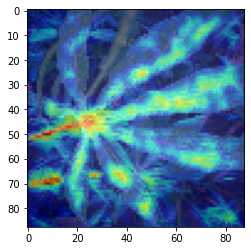

In [41]:
experiment_name = 'demo'
grad_cam = GradCam(model=model, blob_name='conv2', target_layer_names=['0'], use_cuda=True)

img = cv2.imread('../demo/testimage.jpg'.format(i), 1)
img = np.float32(cv2.resize(img, (88, 88))) / 255
img = crop_from_center(img, 88, 88)

inputs = preprocess_image(img)

target_index = None
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic, '{}_{}'.format(i, experiment_name))
gb_model = GuidedBackpropReLUModel(model=model, activation_layer_name = 'ReLU', use_cuda=True)
show_gbs(inputs, gb_model, target_index, mask_dic, '{}_{}'.format(i, experiment_name))